# Binary Neural Networks with ResNet

## Libraries imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from torch.autograd import Variable

import math

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

from copy import deepcopy

## Binary Operation

In [1]:
class BinOp():
    def __init__(self, model, quant_mode='FL_Full'):
        """
        Initialize the binary operation class.
        
        Parameters:
            model (nn.Module): The PyTorch model to binarize.
            quant_mode (str): The quantization mode, either 'FL_Full' or 'FL_Binary'.
        """
        # Count the number of target layers (Conv2d and Linear)
        count_target_layers = 0
        for layer in model.modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                count_target_layers += 1

        # Check if the quant_mode is valid
        if quant_mode not in ['FL_Binary', 'FL_Full']:
            raise ValueError("Invalid quant_mode! Use either 'FL_Full' or 'FL_Binary'.")

        # Set the range of layers to binarize based on quant_mode
        if quant_mode == 'FL_Full':
            start_range = 1
            end_range = count_target_layers - 2
        elif quant_mode == 'FL_Binary':
            start_range = 0
            end_range = count_target_layers - 1

        self.bin_range = numpy.linspace(start_range, end_range, end_range - start_range + 1).astype('int').tolist()
        self.num_of_params = len(self.bin_range)
        self.saved_params = []  # To store original full-precision weights
        self.target_modules = []  # Layers to be binarized

        index = -1
        for layer in model.modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                index += 1
                if index in self.bin_range:
                    temp_weights = layer.weight.data.clone()
                    self.saved_params.append(temp_weights)
                    self.target_modules.append(layer.weight)

    def binarization(self):
        """
        Perform the complete binarization process.
        """
        self.meancenterConvParams()
        self.clampConvParams()
        self.save_params()
        self.binarizeConvParams()

    def meancenterConvParams(self):
        """
        Center the convolutional parameters by subtracting their mean.
        """
        for index in range(self.num_of_params):
            weights = self.target_modules[index].data
            neg_mean = weights.mean(dim=1, keepdim=True).mul(-1).expand_as(weights)
            self.target_modules[index].data.add_(neg_mean)

    def clampConvParams(self):
        """
        Clamp the convolutional parameters to the range [-1, 1].
        """
        for index in range(self.num_of_params):
            self.target_modules[index].data.clamp_(-1.0, 1.0)

    def save_params(self):
        """
        Save the current full-precision parameters.
        """
        for index in range(self.num_of_params):
            self.saved_params[index].copy_(self.target_modules[index].data)

    def binarizeConvParams(self):
        """
        Binarize the convolutional parameters.
        """
        for index in range(self.num_of_params):
            n = self.target_modules[index].data[0].nelement()
            s = self.target_modules[index].data.size()
            if len(s) == 4:
                m = self.target_modules[index].data.norm(1, 3, keepdim=True)\
                        .sum(2, keepdim=True).sum(1, keepdim=True).div(n)
            elif len(s) == 2:
                m = self.target_modules[index].data.norm(1, 1, keepdim=True).div(n)
            self.target_modules[index].data.sign_().mul_(m.expand(s))

    def restore(self):
        """
        Restore the original full-precision parameters.
        """
        for index in range(self.num_of_params):
            self.target_modules[index].data.copy_(self.saved_params[index])

    def updateBinaryGradWeight(self):
        """
        Update the gradients for the binary weights.
        """
        for index in range(self.num_of_params):
            weight = self.target_modules[index].data
            n = weight[0].nelement()
            s = weight.size()
            if len(s) == 4:
                m = weight.norm(1, 3, keepdim=True)\
                        .sum(2, keepdim=True).sum(1, keepdim=True).div(n).expand(s)
            elif len(s) == 2:
                m = weight.norm(1, 1, keepdim=True).div(n).expand(s)
            m = m.clone()
            m[weight.lt(-1.0)] = 0 
            m[weight.gt(1.0)] = 0

            m = m.mul(self.target_modules[index].grad.data)
            m_add = weight.sign().mul(self.target_modules[index].grad.data)
            if len(s) == 4:
                m_add = m_add.sum(3, keepdim=True)\
                        .sum(2, keepdim=True).sum(1, keepdim=True).div(n).expand(s)
            elif len(s) == 2:
                m_add = m_add.sum(1, keepdim=True).div(n).expand(s)

            m_add = m_add.mul(weight.sign())
            self.target_modules[index].grad.data = m.add(m_add).mul(1.0-1.0/s[1]).mul(n)
            self.target_modules[index].grad.data = self.target_modules[index].grad.data.mul(1e+9)
        

## Custom Loss Function

In [2]:
class WeightedLoss(nn.Module):
    """
    Custom Cross-Entropy Loss with support for instance-wise and class-wise weighting.
    
    Parameters:
        aggregate (str): Specifies the aggregation mode for the loss. 
                         Must be one of ['normal_ce_mean', 's_ce_mean', 'sc_ce_mean'].
                         
    Attributes:
        aggregate (str): The aggregation mode for the loss.
    """
    
    def __init__(self, aggregate='mean'):
        super(WeightedLoss, self).__init__()
        
        # Validate the aggregation mode
        valid_aggregate_modes = ['normal_ce_mean', 's_ce_mean', 'sc_ce_mean']
        if aggregate not in valid_aggregate_modes:
            raise ValueError(f"Invalid aggregation mode! Choose from {valid_aggregate_modes}.")
        
        self.aggregate = aggregate

    def forward(self, input_logits, target_labels, weights=None):
        """
        Compute the loss based on the aggregation mode.
        
        Parameters:
            input_logits (torch.Tensor): The predicted logits from the model.
            target_labels (torch.Tensor): The true labels.
            weights (torch.Tensor, optional): The weights for instances or classes.
            
        Returns:
            torch.Tensor: The computed loss.
        """
        
        # Standard Cross-Entropy Loss
        if self.aggregate == 'normal_ce_mean':
            return F.cross_entropy(input_logits, target_labels)
        
        # Instance-wise Weighted Cross-Entropy Loss
        elif self.aggregate == 's_ce_mean':
            # Calculate loss for each instance without reduction
            separate_loss = F.cross_entropy(input_logits, target_labels, reduction='none')
            
            # Ensure weight dimensions match
            if separate_loss.shape != weights.shape:
                raise ValueError(f"Shape mismatch: separate_loss {separate_loss.shape}, weights {weights.shape}")
            
            weights = weights.squeeze_()
            return (separate_loss * Variable(weights.cuda().float())).mean()
        
        # Class-wise Weighted Cross-Entropy Loss
        elif self.aggregate == 'sc_ce_mean':
            batch_size = target_labels.data.nelement()
            
            # Extract weights corresponding to the target labels
            class_weights = weights[:, target_labels.data.cpu().numpy()].diag()
            
            # Calculate loss for each instance without reduction
            separate_loss = F.cross_entropy(input_logits, target_labels, reduction='none')
            
            # Ensure weight dimensions match
            if separate_loss.shape != class_weights.shape:
                raise ValueError(f"Shape mismatch: separate_loss {separate_loss.shape}, class_weights {class_weights.shape}")
            
            return (separate_loss * Variable(class_weights.cuda().float())).mean()


## ResNet Implementation

In [3]:
class BinActive(torch.autograd.Function):
    """
    This class implements a binarization activation function. 
    It binarizes the input activations using the sign function and allows gradients to pass during backpropagation.
    
    To use this class, simply call it as a function:
        binarized_activation = BinActive()(input_tensor)
    """
    
    @staticmethod
    def forward(ctx, input_tensor):
        """
        Forward pass to binarize the input.
        
        Args:
            ctx: Context object to save tensors for backward pass.
            input_tensor: Input tensor to be binarized.
        
        Returns:
            Binarized tensor.
        """
        
        # Save the input tensor for backward pass
        ctx.save_for_backward(input_tensor)
        
        # Perform binarization
        binarized_output = input_tensor.sign()
        
        return binarized_output

    @staticmethod
    def backward(ctx, grad_output):
        """
        Backward pass to allow gradients to pass through.
        
        Args:
            ctx: Context object containing saved tensors.
            grad_output: Gradient tensor from the next layer.
        
        Returns:
            Gradient tensor to pass to the previous layer.
        """
        
        # Retrieve the saved input tensor
        input_tensor, = ctx.saved_tensors
        
        # Create a gradient tensor that allows gradients to pass 
        # only where the input tensor values are between -1 and 1
        grad_input = grad_output.clone()
        grad_input = grad_input * (input_tensor <= 1).float() * (input_tensor >= -1).float()
        
        return grad_input

class BinConv2d(nn.Module):
    """
    Implements a binary convolutional layer.
    
    This class can act as a drop-in replacement for a standard nn.Conv2d layer.
    The layer includes batch normalization and an activation function.
    
    Args:
        input_channels (int): Number of input channels.
        output_channels (int): Number of output channels.
        kernel_size (int): Size of the convolutional kernel.
        stride (int): Stride of the convolution.
        padding (int): Padding added to the input.
        groups (int): Number of blocked connections from input to output channels.
        dropout (float): Dropout rate.
        Linear (bool): Whether to use linear activation. Default is False.
        is_ac (bool): Whether to apply activation function. Default is True.
    """
    
    def __init__(self, input_channels, output_channels, kernel_size, stride=1, padding=0, groups=1, dropout=0, Linear=False, is_ac=True):
        super(BinConv2d, self).__init__()
        
        # Initialize layer parameters
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.groups = groups
        self.dropout_rate = dropout
        self.is_linear = Linear
        self.is_ac = is_ac

        # Batch Normalization
        if not self.is_linear:
            self.bn = nn.BatchNorm2d(input_channels, eps=1e-4, momentum=0.1, affine=True)
            self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
        else:
            self.bn = nn.BatchNorm1d(input_channels, eps=1e-4, momentum=0.1, affine=True)
            self.linear = nn.Linear(input_channels, output_channels)

        # Activation Function
        self.relu = nn.ReLU(inplace=True)

        # Dropout Layer
        if self.dropout_rate != 0:
            self.dropout = nn.Dropout(self.dropout_rate)
        else:
            self.dropout = None

    def forward(self, x):
        """
        Forward pass through the layer.
        
        Args:
            x (Tensor): Input tensor.
        
        Returns:
            Tensor: Output of the layer.
        """
        
        # Apply Batch Norm
        x = self.bn(x)
        
        # Binarize the output
        x = BinActive.apply(x)

        # Apply Dropout if specified
        if self.dropout is not None:
            x = self.dropout(x)

        # Apply Convolution or Linear layer
        if not self.is_linear:
            x = self.conv(x)
        else:
            x = self.linear(x)
        
        # Apply Activation if specified
        if self.is_ac:
            x = self.relu(x)

        return x

class RealConv2d(nn.Module):
    """
    Implements a real-valued convolutional layer.
    
    This class can act as a drop-in replacement for a standard nn.Conv2d layer.
    The layer includes batch normalization and an activation function.
    
    Args:
        input_channels (int): Number of input channels.
        output_channels (int): Number of output channels.
        kernel_size (int): Size of the convolutional kernel.
        stride (int): Stride of the convolution.
        padding (int): Padding added to the input.
        groups (int): Number of blocked connections from input to output channels.
        dropout (float): Dropout rate.
        Linear (bool): Whether to use linear activation. Default is False.
    """
    
    def __init__(self, input_channels, output_channels, kernel_size, stride=1, padding=0, groups=1, dropout=0, Linear=False):
        super(RealConv2d, self).__init__()
        
        # Initialize layer parameters
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.groups = groups
        self.dropout_rate = dropout
        self.is_linear = Linear

        # Batch Normalization
        if not self.is_linear:
            self.bn = nn.BatchNorm2d(input_channels, eps=1e-4, momentum=0.1, affine=True)
            self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
        else:
            self.bn = nn.BatchNorm1d(input_channels, eps=1e-4, momentum=0.1, affine=True)
            self.linear = nn.Linear(input_channels, output_channels)
        
        # Activation Function
        self.relu = nn.ReLU(inplace=True)
        
        # Dropout Layer
        if self.dropout_rate != 0:
            self.dropout = nn.Dropout(self.dropout_rate)
        else:
            self.dropout = None

    def forward(self, x):
        """
        Forward pass through the layer.
        
        Args:
            x (Tensor): Input tensor.
        
        Returns:
            Tensor: Output of the layer.
        """
        
        # Apply Batch Norm
        x = self.bn(x)
        
        # Apply Dropout if specified
        if self.dropout is not None:
            x = self.dropout(x)
        
        # Apply Convolution or Linear layer
        if not self.is_linear:
            x = self.conv(x)
        else:
            x = self.linear(x)
        
        # Apply Activation
        x = self.relu(x)

        return x

def binary_conv3x3(in_channels, out_channels, stride=1, is_activation=True):
    """
    Factory function for creating a 3x3 binary convolutional layer with padding.
    
    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        stride (int): Stride of the convolution. Default is 1.
        is_activation (bool): Whether or not to include an activation function. Default is True.
        
    Returns:
        BinConv2d: 3x3 binary convolutional layer.
    """
    return BinConv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                     padding=1, is_ac=is_activation)

def standard_conv3x3(in_channels, out_channels, stride=1):
    """
    Factory function for creating a standard 3x3 convolutional layer with padding.
    
    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        stride (int): Stride of the convolution. Default is 1.
        
    Returns:
        nn.Conv2d: 3x3 standard convolutional layer.
    """
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                     padding=1)

def initialize_model(model):
    """
    Initialize model weights for BinConv2d and nn.BatchNorm2d layers.
    
    Args:
        model (nn.Module): The model to initialize.
    """
    for module in model.modules():
        if isinstance(module, BinConv2d):
            n = module.kernel_size[0] * module.kernel_size[1] * module.out_channels
            module.weight.data.normal_(0, math.sqrt(2. / n))
        elif isinstance(module, nn.BatchNorm2d):
            module.weight.data.fill_(1)
            module.bias.data.zero_()

class BasicBlock(nn.Module):
    """
    BasicBlock Class for ResNet.
    
    Attributes:
        expansion (int): The expansion factor for the output. Default is 1.
    """
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """
        Initialize a BasicBlock.
        
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int): Stride of the convolutional layer. Default is 1.
            downsample (nn.Module, optional): The downsample layer if needed.
        """
        super(BasicBlock, self).__init__()

        # First binary convolutional layer
        self.conv1 = binary_conv3x3(in_channels, out_channels, stride=stride, is_activation=True)
        
        # Second binary convolutional layer
        self.conv2 = binary_conv3x3(out_channels, out_channels, is_activation=False)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        """
        Forward pass for BasicBlock.
        
        Args:
            x (Tensor): Input tensor.
        
        Returns:
            Tensor: Output tensor.
        """
        residual = x.clone()

        out = self.conv1(x)
        out = self.conv2(out)

        if self.downsample is not None:
            residual = self.downsample(residual)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    """
    Bottleneck Class for ResNet.
    
    Attributes:
        expansion (int): The expansion factor for the output. Default is 4.
    """
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """
        Initialize a Bottleneck block.
        
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int): Stride of the convolutional layer. Default is 1.
            downsample (nn.Module, optional): The downsample layer if needed.
        """
        super(Bottleneck, self).__init__()

        # First binary convolutional layer
        self.conv1 = BinConv2d(in_channels, out_channels, kernel_size=1, is_ac=True)
        
        # Second binary convolutional layer
        self.conv2 = BinConv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, is_ac=True)
        
        # Third binary convolutional layer
        self.conv3 = BinConv2d(out_channels, out_channels * self.expansion, kernel_size=1, is_ac=False)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        """
        Forward pass for Bottleneck.
        
        Args:
            x (Tensor): Input tensor.
        
        Returns:
            Tensor: Output tensor.
        """
        residual = x

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    """Base class for ResNet models."""
    
    def __init__(self):
        super(ResNet, self).__init__()

    def _make_layer(self, block, planes, blocks, stride=1):
        """Constructs a layer block for ResNet.
        
        Args:
            block: The class for either BasicBlock or Bottleneck.
            planes: The number of filters in the block.
            blocks: The number of blocks in the layer.
            stride: The stride of the first block.
            
        Returns:
            nn.Sequential: A sequence of blocks.
        """
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = BinConv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, is_ac=False)
        
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
            
        return nn.Sequential(*layers)

    def forward(self, x):
        """Forward pass for ResNet."""
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.bn1(x)
        x = self.relu1(x)  # Changed from tanh1 to relu1 for clarity
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.bn2(x)
        x = self.relu2(x)  # Changed from tanh2 to relu2 for clarity
        x = self.fc(x)
        
        return x


class ResNet_imagenet(ResNet):
    """ResNet class for the imagenet dataset."""
    
    def __init__(self, num_classes=1000, block=Bottleneck, layers=[3, 4, 23, 3]):
        super(ResNet_imagenet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.bn2 = nn.BatchNorm1d(512 * block.expansion)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        # Removed regime as it should be part of the training script, not the model


class ResNet_cifar10(ResNet):
    """ResNet class for the CIFAR-10 dataset."""
    
    def __init__(self, num_classes=10, block=BasicBlock, depth=18):
        super(ResNet_cifar10, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool = nn.Identity()  # No maxpooling for CIFAR-10
        n = int((depth - 2) / 6)
        self.layer1 = self._make_layer(block, 16, n)
        self.layer2 = self._make_layer(block, 32, n, stride=2)
        self.layer3 = self._make_layer(block, 64, n, stride=2)
        self.layer4 = nn.Identity()  # No layer4 for CIFAR-10
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.bn2 = nn.BatchNorm1d(64 * block.expansion)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc = nn.Linear(64 * block.expansion, num_classes)
        # Removed regime as it should be part of the training script, not the model


def resnet_factory(model_name, pretrained=None, **kwargs):
    """Factory function for creating a ResNet model.
    
    Args:
        model_name (str): Name of the model to create.
        pretrained (str, optional): Path to the pretrained model.
        
    Returns:
        nn.Module: The ResNet model.
    """
    assert model_name in ['ResNet_imagenet', 'ResNet_cifar10'], 'No such model!'
    
    if model_name == 'ResNet_imagenet':
        model = ResNet_imagenet(**kwargs)
    elif model_name == 'ResNet_cifar10':
        model = ResNet_cifar10(**kwargs)

    if pretrained is not None:
        pretrained_model = torch.load(pretrained)
        model.load_state_dict(pretrained_model['state_dict'])

    return model


## Model Training

Files already downloaded and verified
[1, 100] loss: 1.988428931236267
[1, 200] loss: 1.7343603873252869
[1, 300] loss: 1.6337925219535827
[2, 100] loss: 1.5202152884006501
[2, 200] loss: 1.4509035897254945
[2, 300] loss: 1.4092435085773467
[3, 100] loss: 1.3355900394916533
[3, 200] loss: 1.3175048673152923
[3, 300] loss: 1.277860779762268
[4, 100] loss: 1.2530415010452272
[4, 200] loss: 1.2327501451969147
[4, 300] loss: 1.2218678712844848
[5, 100] loss: 1.1878383553028107
[5, 200] loss: 1.164573928117752
[5, 300] loss: 1.1535036849975586
[6, 100] loss: 1.1382748484611511
[6, 200] loss: 1.1205490905046462
[6, 300] loss: 1.1010689854621887
[7, 100] loss: 1.079983658194542
[7, 200] loss: 1.0538219946622849
[7, 300] loss: 1.064083217382431
[8, 100] loss: 1.0423555153608322
[8, 200] loss: 1.0396583753824233
[8, 300] loss: 1.0314743781089784
[9, 100] loss: 0.9994986468553543
[9, 200] loss: 1.0135605812072754
[9, 300] loss: 1.0177223813533782
[10, 100] loss: 0.9803272944688797
[10, 200] loss

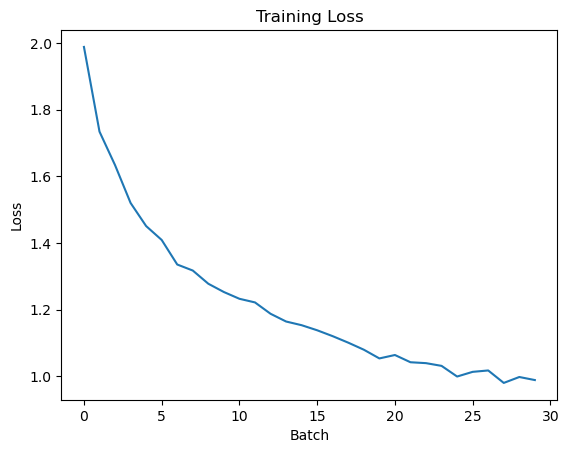

GroundTruth:    cat horse horse   dog
plane: 13.52%
car: 0.76%
bird: 8.38%
cat: 1.41%
deer: 1.01%
dog: 0.11%
frog: 6.69%
horse: 0.16%
ship: 66.51%
truck: 1.46%
Finished Training


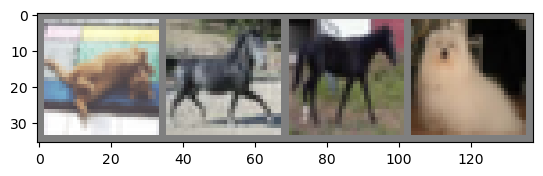

In [4]:
# Hyperparameters
epochs = 10
lr = 0.001
batch_size = 128

# Initialize model, loss function, and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet_cifar10().to(device)
bin_op = BinOp(net)
criterion = WeightedLoss(aggregate='normal_ce_mean')
optimizer = optim.Adam(net.parameters(), lr=lr)

# Data loading
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Training function
def train(trainloader, model, criterion, optimizer):
    loss_list = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            bin_op.binarization()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            bin_op.restore()
            bin_op.updateBinaryGradWeight()
            optimizer.step()
            
            running_loss += loss.item()
            if i % 100 == 99:
                avg_loss = running_loss / 100
                print(f"[{epoch + 1}, {i + 1}] loss: {avg_loss}")
                loss_list.append(avg_loss)
                running_loss = 0.0
    return loss_list

# Function to show images
def imshow(img):
    if isinstance(img, torch.Tensor):
        img = img.numpy()
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

# Function to display class probabilities
def display_probabilities(output):
    probabilities = torch.softmax(output, dim=1)[0] * 100
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    for i in range(10):
        print(f'{classes[i]}: {probabilities[i].item():.2f}%')

# Train the model
loss_list = train(trainloader, net, criterion, optimizer)

# Plotting the training loss
plt.figure()
plt.plot(loss_list)
plt.title('Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

# Classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Show some test images and their class probabilities
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images[:4].to(device))
display_probabilities(outputs.detach().cpu())

print("Finished Training")


## Model Evaluation

In [5]:
# Load CIFAR-10 test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

# Evaluation function
def evaluate(testloader, model):
    correct = 0
    total = 0
    class_probs = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Get class probabilities for the first batch
            if len(class_probs) == 0:
                class_probs.append(torch.softmax(outputs, dim=1).cpu().numpy())
    
    print(f'Accuracy of the network on the 10000 test images: {(100 * correct / total):.2f}%')
    
    # Display class probabilities for some images in the first batch
    batch_probs = class_probs[0]
    for i in range(4):
        print(f"\nImage {i+1}:")
        for j in range(10):
            print(f'{classes[j]}: {batch_probs[i][j]*100:.2f}%')

# Evaluate the model
evaluate(testloader, net)


Files already downloaded and verified
Accuracy of the network on the 10000 test images: 54.89%

Image 1:
plane: 2.63%
car: 0.96%
bird: 2.50%
cat: 25.89%
deer: 0.29%
dog: 64.15%
frog: 2.18%
horse: 0.41%
ship: 0.61%
truck: 0.38%

Image 2:
plane: 2.61%
car: 0.25%
bird: 0.02%
cat: 0.00%
deer: 0.00%
dog: 0.00%
frog: 0.00%
horse: 0.00%
ship: 96.61%
truck: 0.50%

Image 3:
plane: 0.42%
car: 0.37%
bird: 0.07%
cat: 0.02%
deer: 0.12%
dog: 0.00%
frog: 0.00%
horse: 0.02%
ship: 98.78%
truck: 0.19%

Image 4:
plane: 55.78%
car: 3.11%
bird: 3.83%
cat: 0.24%
deer: 0.48%
dog: 0.03%
frog: 0.08%
horse: 0.07%
ship: 34.93%
truck: 1.45%


Accuracy of the network on the 10000 test images: 54.89%

Image 1 (Ground Truth: cat):


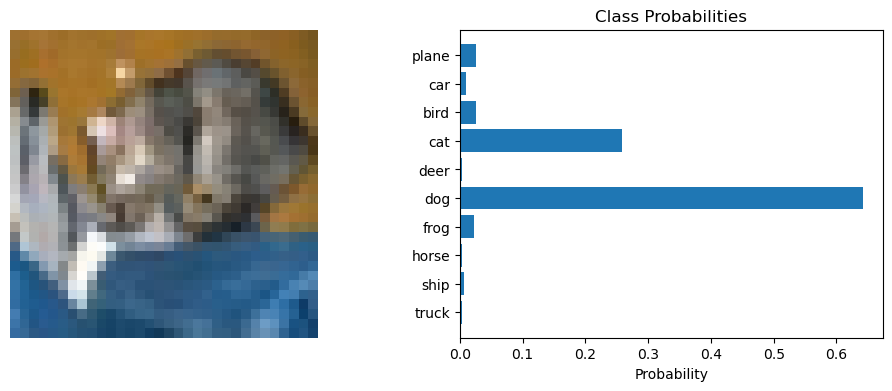


Image 2 (Ground Truth: ship):


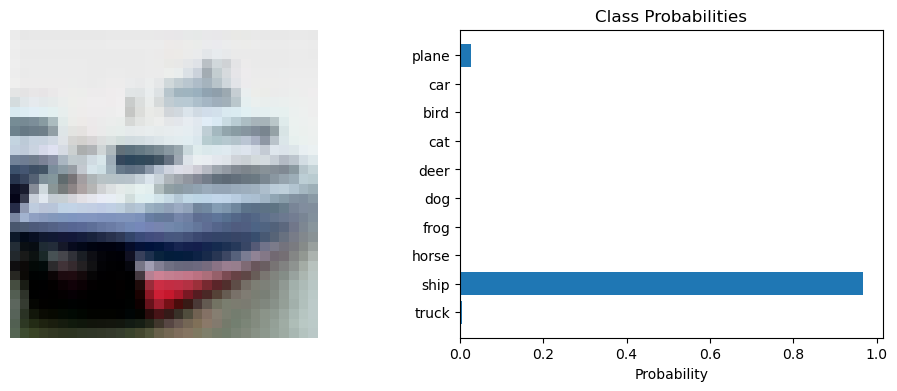


Image 3 (Ground Truth: ship):


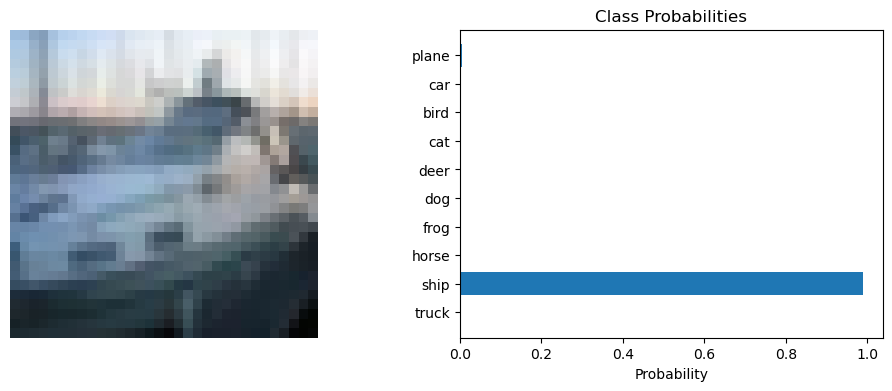


Image 4 (Ground Truth: plane):


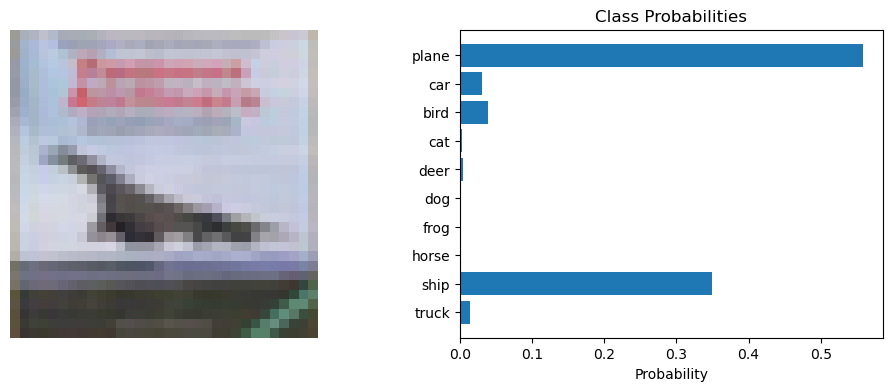

In [6]:
# Evaluate function with image and class probabilities display
def evaluate(testloader, model):
    correct = 0
    total = 0
    class_probs = []
    sample_images = []
    sample_labels = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Get class probabilities for the first batch
            if len(class_probs) == 0:
                class_probs.append(torch.softmax(outputs, dim=1).cpu().numpy())
                sample_images.append(images.cpu())
                sample_labels.append(labels.cpu())
    
    print(f'Accuracy of the network on the 10000 test images: {(100 * correct / total):.2f}%')
    
    # Display class probabilities for some images in the first batch
    batch_probs = class_probs[0]
    sample_images = sample_images[0]
    sample_labels = sample_labels[0]
    for i in range(4):  # Change this to display more/fewer images
        image = (sample_images[i] / 2 + 0.5).numpy().transpose((1, 2, 0))
        print(f"\nImage {i+1} (Ground Truth: {classes[sample_labels[i]]}):")
        show_image_and_probs(image, batch_probs[i])

# Function to show image along with class probabilities
def show_image_and_probs(image, probs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Show image
    ax1.imshow(image)
    ax1.axis('off')
    
    # Show class probabilities
    y_pos = np.arange(len(classes))
    ax2.barh(y_pos, probs, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(classes)
    ax2.invert_yaxis()
    ax2.set_xlabel('Probability')
    ax2.set_title('Class Probabilities')

    plt.show()

# Evaluate the model
evaluate(testloader, net)


## Ensemble - Boosting

In [7]:
# Ensemble evaluation function
def evaluate_ensemble(valloader, ensemble, ensemble_weights):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device)
            ensemble_output = torch.zeros([labels.shape[0], 10]).to(device)
            for model, weight in zip(ensemble, ensemble_weights):
                outputs = model(images)
                ensemble_output += weight * outputs
            _, predicted = torch.max(ensemble_output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

def reset_model_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
        else:
            for sub_layer in layer.children():
                if hasattr(sub_layer, 'reset_parameters'):
                    sub_layer.reset_parameters()

class IndexedDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset

    def __getitem__(self, index):
        data, label = self.original_dataset[index]
        return data, label, index

    def __len__(self):
        return len(self.original_dataset)


In [8]:
# Hyperparameters
epochs = 50
lr = 0.001
batch_size = 128
n_ensemble = 15

# Initialize model, loss function, and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet_cifar10().to(device)
bin_op = BinOp(net)
criterion = WeightedLoss(aggregate='normal_ce_mean')
optimizer = optim.Adam(net.parameters(), lr=lr)


def train_with_ensemble(trainloader, valloader, model, criterion, optimizer, epochs, n_ensemble=3):
    ensemble_models = []
    ensemble_weights = []
    best_ensemble_accuracy = 0.0
    
    weights = torch.ones(len(trainloader.dataset)).to(device)
    
    for ensemble_count in range(n_ensemble):
        print(f"Training model {ensemble_count + 1} in the ensemble...")
        
        # Update the weighted random sampler
        # new_trainloader = DataLoader(trainloader.dataset, batch_size=trainloader.batch_size, sampler=sampler)
        sampler = WeightedRandomSampler(weights, len(trainloader.dataset))
        indexed_train_dataset = IndexedDataset(trainloader.dataset)
        new_trainloader = DataLoader(indexed_train_dataset, batch_size=trainloader.batch_size, sampler=sampler)
        
        # Reset model weights if needed
        reset_model_weights(model)
        
        # Train the model
        loss_list = []
        for epoch in range(epochs):
            running_loss = 0.0
            for i, data in enumerate(new_trainloader, 0):
                inputs, labels, indices = data[0].to(device), data[1].to(device), data[2]
                # inputs, labels = data[0].to(device), data[1].to(device)
                
                bin_op.binarization()
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                bin_op.restore()
                bin_op.updateBinaryGradWeight()
                optimizer.step()
                
                running_loss += loss.item()
                if i % 100 == 99:
                    avg_loss = running_loss / 100
                    print(f"[{epoch + 1}, {i + 1}] loss: {avg_loss}")
                    loss_list.append(avg_loss)
                    running_loss = 0.0
        
        # Evaluate the trained model
        model_accuracy = evaluate_ensemble(valloader, [model], [1.0])
        ensemble_weights.append(model_accuracy)
        
        # Save this model to the ensemble
        ensemble_models.append(deepcopy(model.state_dict()))
        
        # Update the weights for misclassified samples
        with torch.no_grad():
            for i, data in enumerate(new_trainloader, 0):  # Use new_trainloader instead of trainloader
                inputs, labels, indices = data[0].to(device), data[1].to(device), data[2].to(device)  # Get indices as well, and move to device
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                wrong_idx = (predicted != labels)
                weights[indices[wrong_idx]] += 1.0  # Use indices to update weights

        
        # Evaluate the ensemble
        temp_ensemble = [deepcopy(model) for _ in range(len(ensemble_models))]
        for idx, state_dict in enumerate(ensemble_models):
            temp_ensemble[idx].load_state_dict(state_dict)
        
        new_ensemble_accuracy = evaluate_ensemble(valloader, temp_ensemble, ensemble_weights)
        
        if new_ensemble_accuracy > best_ensemble_accuracy:
            best_ensemble_accuracy = new_ensemble_accuracy
        else:
            ensemble_models.pop()
            ensemble_weights.pop()
        
        # Normalize ensemble_weights
        total_weight = sum(ensemble_weights)
        ensemble_weights = [weight / total_weight for weight in ensemble_weights]
        
    return ensemble_models, ensemble_weights, loss_list


In [9]:
# Call the train_with_ensemble function to train the ensemble models
ensemble_models, ensemble_weights, loss_list = train_with_ensemble(
    trainloader, testloader, net, criterion, optimizer, epochs, n_ensemble
)

# Create deep copies of the base model for each ensemble member
temp_ensemble = [deepcopy(net) for _ in range(len(ensemble_models))]
for idx, state_dict in enumerate(ensemble_models):
    temp_ensemble[idx].load_state_dict(state_dict)

# Evaluate the ensemble
ensemble_accuracy = evaluate_ensemble(testloader, temp_ensemble, ensemble_weights)

print(f"Ensemble Accuracy: {ensemble_accuracy}")


Training model 1 in the ensemble...
[1, 100] loss: 1.9872406327724457
[1, 200] loss: 1.7640420520305633
[1, 300] loss: 1.6396432101726532
[2, 100] loss: 1.5391672730445862
[2, 200] loss: 1.4792481577396392
[2, 300] loss: 1.43183092713356
[3, 100] loss: 1.3654741251468658
[3, 200] loss: 1.3225467693805695
[3, 300] loss: 1.2946428096294402
[4, 100] loss: 1.2552246761322021
[4, 200] loss: 1.2448956614732742
[4, 300] loss: 1.1838169038295745
[5, 100] loss: 1.1674246847629548
[5, 200] loss: 1.1620305168628693
[5, 300] loss: 1.1501968258619308
[6, 100] loss: 1.1357596921920776
[6, 200] loss: 1.1076109778881074
[6, 300] loss: 1.089013283252716
[7, 100] loss: 1.057942556142807
[7, 200] loss: 1.0767008340358735
[7, 300] loss: 1.0561875253915787
[8, 100] loss: 1.0341007256507873
[8, 200] loss: 1.0266148900985719
[8, 300] loss: 1.041714345216751
[9, 100] loss: 1.0181425577402115
[9, 200] loss: 1.024702877998352
[9, 300] loss: 1.0127678561210631
[10, 100] loss: 0.9986615604162217
[10, 200] loss: 1